<h1>Text Summarization Unsupervised Learning</h1>
<h3>Author: Chris Gang Liu</h3>
<p>
1- Background: a summary of available solutions for text summarization. <br />
2- Models: Explain how the models work <br />
3- Results: Compare two models using the three selected text les and
report the results here. <br />
4- conclusion: Summarize your paper by a guideline for an enduser so that the enduser can select the best text summarization approach
based on your findings.<br />
    </p>
    
#### References

Aleksander Kołcz, Features Selection for Text Summuarization: https://www.researchgate.net/profile/Jugal_Kalita/publication/221613265_Summarization_as_Feature_Selection_for_Text_Categorization/links/54b6a2180cf24eb34f6d4c17/Summarization-as-Feature-Selection-for-Text-Categorization.pdf <br>
Jaiprakash Verma, Evaulation of unsupervisied Text Summarization: https://www.researchgate.net/publication/317610956_Evaluation_of_Unsupervised_Learning_based_Extractive_Text_Summarization_Technique_for_Large_Scale_Review_and_Feedback_Data<br>
Makbule Gulcin Ozsoy, Latent Semantic Analysis approach: https://www.researchgate.net/publication/220195824_Text_summarization_using_Latent_Semantic_Analysis<br>
Spacy Frequency Approach: https://github.com/luisfredgs/extractive-text-summarization<br>
Mohammad Etemad, Transportation Modes Classification Using Feature Engineering: https://www.researchgate.net/publication/326696576_Transportation_Modes_Classification_Using_Feature_Engineering<br>


Common Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from textblob import TextBlob
import distance
import string
from pprint import pprint
import collections, itertools
import nltk
from nltk.corpus import stopwords
import nltk.classify.util, nltk.metrics
from nltk import cluster
from nltk.metrics import *
from nltk.collocations import BigramCollocationFinder
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import os
import datetime
import statistics
import difflib
import math
from scipy import stats
from scipy.stats import mode
import IPython
import IPython.display
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

Models Buildup Libraries

In [4]:
from gensim.summarization import summarize
from gensim.summarization import keywords
from tika import parser # pip install tika
from numpy.linalg import svd as singular_value_decomposition
from operator import attrgetter
from collections import namedtuple
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
import argparse
import en_core_web_sm
nlp = spacy.load('en')
from collections import Counter

Models Comparsion Metrics Libraries

In [1]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
import warnings

warnings.filterwarnings('ignore')

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Reusable funcations
##### Bring OOP concepts in

In [54]:
class solutionGuildeline:
    def __init__(self):
        self.df = pd.DataFrame(columns=['text','abstract','sent_tokens','sent_tokens_counts','word_tokens','word_tokens_counts','normalized_text'
                                        ,'gensim_summarizations','latent_semantic_summarization','spacy_extraction_summarization'
                                        ,'AI_genims_scores','AI_latent_scores','AI_frequency_scores'])
        self.abstracts = []
        self.texts = []
        self.normalized_texts = []
        self.gensim_summarizations = []
        self.latent_semantic_summarizations = []
        self.spacy_extraction_summarizations = []
        self.tokenizedSents = [] # tokenize the whole text sents
        self.tokenizedSents_counts = [] #count the whole text sents
        self.tokenizedwords = [] # tokenize the whole text words
        self.tokenizedwords_counts = []  # count the whole text words  
        self.tokenizedAbstractSents = []  # human abstraction sentences 
        self.tokenizedAbstractSents_counts = [] # human abstraction sentences count
        self.tokenizedAbstractwords = [] # human abstraction words
        self.tokenizedAbstractwords_counts = [] # # human abstraction words count
        self.AI_genims_scores = []
        self.AI_latent_scores = []
        self.AI_frequency_scores = []
        self.Tfidf_scores = []
        self.MIN_DIMENSIONS = 3
        self.REDUCTION_RATIO = 1/1
    
    def _dataExtraction(self):
        text1_raw = open('StrategiesEducation.txt', 'r').read()
        text2_raw = open('Mechoulan_656370.txt', 'r', encoding="utf-8").read()
        text3_raw = open('newconstruction.txt', 'r').read()
        text1 = text1_raw
        self.texts.append(text1)
        text2 = text2_raw
        self.texts.append(text2)
        text3 = text3_raw
        self.texts.append(text3)
        self.df['text'] = self.texts
        return self.df
        
    def _preprocessData(self):
        self.normalized_texts.append(self.normalizeText(self.texts[0]))
        self.normalized_texts.append(self.normalizeText(self.texts[1]))
        self.normalized_texts.append(self.normalizeText(self.texts[2]))
        self.df['normalized_text'] = self.normalized_texts
        return self.df
    
    #unsupervised text summarization needs human made summarization as the reference for evaluating models.
    #reference paper: https://www.researchgate.net/publication/317610956_Evaluation_of_Unsupervised_Learning_based_Extractive_Text_Summarization_Technique_for_Large_Scale_Review_and_Feedback_Data    
    def _featurePreparation(self):
        # add author abastract for evaluation later on
        mechoulan_abstract = "This article examines how the increase in the incarceration of black men and the sex ratio imbalance it induces shape the behavior of young black women. Combining data from the Bureau of Justice Statistics and the Current Population Survey to match male incar- ceration rates with individual observations over two decades, I show that black male incarceration lowers the odds of black non- marital teenage fertility while increasing young black women’s school attainment and early employment. These results can account for the sharp bridging of the racial gap over the 1990s for a range of socioeconomic outcomes among females."
        StrategiesEducation_abstract  = "In  2012, analysts estimated  90% of the  world’s data  had come  into existence  within the  previous 2  years (Vesset et al., 2014). Organizations  in all sectors  are struggling with this  volume of data, confident that despite the velocity  at which  it is growing, and the variety  of its formats, there is value. The goal is to  transition  from being data-­--rich to being information-­--rich and knowledge-­--rich, for which  we need  both  data scientists  and people capable of working effectively with data. The McKinsey Global Institute suggested that at current training rates, in the US alone there will be 140,000 - 190,000  more  jobs than trained data scientists by 2018  (Manyika  et al., 2011). On the literacy, fluency, mastery scale, a data scientist would have achieved mastery. However, the same report also estimated a  1,500,000  employee  shortfall of data-savvy analysts  and managers  capable of working with the data to make effective  decisions (Manyika et  al., 2011);  IDC  suggests  a  similar  number  (Vesset  et  al.,  2014).  This latter set of skills is what we refer to as data literacy." \
        +"Across academic disciplines and throughout the private sector, we are recognizing a growing need for data-­--literate graduates from all  backgrounds. The recent Tri-­--Council consultation document on digital scholarship  (Government of Canada, 2013) recognizes this challenge, and  the issue of training in particular: “Digital  data are the raw materials  of the knowledge economy, and are becoming increasingly important for all  areas of society, including industry… The same may be said of the capacity to capture, manage and preserve it, or the requisite training of personnel who can operate effectively  in  this milieu” (Government of Canada, 2013). This recognition prompts the core question addressed in this report:  How  can  post-secondary institutions  in Canada best equip graduates  with the knowledge, understanding, and skills required for the data-­--rich knowledge economy?" \
        +"We addressed this question by  examining existing strategies and best practices for teaching data  literacy, synthesizing documented explicit knowledge (from both formal and informal literature) using a narrative-­--synthesis  methodology. When necessary, we  used our team''s expertise  to aid in synthesizing and summarizing; this  expertise spans  multiple disciplines, including Science, Computer Science, Business, Information Management, Arts and Social Sciences, and Education. "\
        +"We begin by establishing the skills that comprise data literacy. Data literacy is the ability to collect, manage, evaluate, and apply data, in a critical manner. We define the core skills and competencies that  comprise data literacy, using a thematic analysis of  the elements  of data literacy described in peer-­--reviewed literature. These competencies (23 in  total) and  their skills, knowledge, and expected tasks (64 in total)  are organized under the top-­--level  elements of the definition (data, collect, manage, evaluate, apply) and  are categorized  as conceptual competencies, core competencies, and  advanced  competencies. This view of data literacy is central to our synthesis, which includes  two primary sections: the context  and strategic value of  data literacy education, and best  practices  for  teaching data literacy across disciplines. There also remains much  we do not know, and  further steps that need  to be taken, to understand  data literacy  instructions. "
        newconstruction_abstract = "The work aims to present the study of the business processes of small building companies. The study led to the development of a basic model of business processes. For this, we applied the multiple case study method as main technique to identify the common processes among the companies studied. The study included five building companies of the city of Curitiba, Paraná, Brazil. Data were collected through semi-structured interviews, document analysis and direct observations in loco. Based on the information obtained, the business process modeling was developed using BPMN notation (Business Process Modeling Notation). Thus, the study allowed the development of a basic model that presents the best practices based on the PCF model (Process Classification Framework), in view of, adequate and compatible with the reality of the organizations that work in the subsector of buildings. The framework obtains a unique view of the processes, presenting the main activities of each business process, with the intention of transmitting a single language within the company."
        self.abstracts.append(self.normalizeText(StrategiesEducation_abstract))
        self.abstracts.append(self.normalizeText(mechoulan_abstract))
        self.abstracts.append(self.normalizeText(newconstruction_abstract))
        self.df['abstract'] = self.abstracts
        self.countTextSents() # count human abstract sent/word count to decide model reduction ratio
        self.countHumanAbstractSents() # count human abstract sent/word count to decide model reduction ratio
        return self.df
        
    def _buildingGensimModel(self):
        self.gensim_summarizations=[]
        text1 = self.df.loc[0]['text']
        text2 = self.df.loc[1]['text']
        text3 = self.df.loc[2]['text']
        genism_summarize1 = summarize(text1, ratio=self.tokenizedAbstractSents_counts[0]/self.tokenizedSents_counts[0]) #api wordcount/ ratio.
        print("___________________genism summarized text 1:")
        print(genism_summarize1)
        self.gensim_summarizations.append(genism_summarize1)
        genism_summarize2 = summarize(text2, ratio=self.tokenizedAbstractSents_counts[1]/self.tokenizedSents_counts[1])
        print("___________________genism summarized text 2:")
        print(genism_summarize2)
        self.gensim_summarizations.append(genism_summarize2)
        genism_summarize3 = summarize(text3, ratio=self.tokenizedAbstractSents_counts[2]/self.tokenizedSents_counts[2])
        print("___________________genism summarized text 3:")
        print(genism_summarize3)
        self.gensim_summarizations.append(genism_summarize3)
        self.df['gensim_summarizations'] = self.gensim_summarizations
        return self.df
    
    def _buildingLatentModel(self):
        self.latent_semantic_summarizations = []
        text1_normalized = self.df.loc[0]['normalized_text']
        text2_normalized = self.df.loc[1]['normalized_text']
        text3_normalized = self.df.loc[2]['normalized_text'] 
        text1_sent_arr = self.df.loc[0]['sent_tokens']
        text2_sent_arr = self.df.loc[1]['sent_tokens']
        text3_sent_arr = self.df.loc[2]['sent_tokens']
        dictionary1 = self.create_dictionary(text1_normalized)
        dictionary2 = self.create_dictionary(text2_normalized)
        dictionary3 = self.create_dictionary(text3_normalized)
        matrix1 = self.create_matrix(text1_sent_arr, dictionary1)
        matrix2 = self.create_matrix(text2_sent_arr, dictionary2)
        matrix3 = self.create_matrix(text3_sent_arr, dictionary3)
        matrix1 = self.compute_term_frequency(matrix1)
        matrix2 = self.compute_term_frequency(matrix2)
        matrix3 = self.compute_term_frequency(matrix3)
        u1, sigma1, v1 = singular_value_decomposition(matrix1, full_matrices=False)
        u2, sigma2, v2 = singular_value_decomposition(matrix2, full_matrices=False)
        u3, sigma3, v3 = singular_value_decomposition(matrix3, full_matrices=False)
        ranks1 = list(self.compute_ranks(sigma1, v1))
        ranks2 = list(self.compute_ranks(sigma2, v2))
        ranks3 = list(self.compute_ranks(sigma3, v3))
        summary1 = self.get_best_sentences(text1_sent_arr, self.tokenizedAbstractSents_counts[0], ranks1)
        summary2 = self.get_best_sentences(text2_sent_arr, self.tokenizedAbstractSents_counts[1], ranks2)
        summary3 = self.get_best_sentences(text3_sent_arr, self.tokenizedAbstractSents_counts[2], ranks3)
        self.latent_semantic_summarizations.append(" ".join(summary1))
        self.latent_semantic_summarizations.append(" ".join(summary2))
        self.latent_semantic_summarizations.append(" ".join(summary3))
        print("___________________latent_semantic summarized text 1:")
        print(self.latent_semantic_summarizations[0])
        print("___________________latent_semantic summarized text 2:")
        print(self.latent_semantic_summarizations[1])
        print("___________________latent_semantic summarized text 3:")
        print(self.latent_semantic_summarizations[2])
        self.df['latent_semantic_summarization'] = self.latent_semantic_summarizations
        return self.df

    def _buildingSpacyModel(self):
        text1_normalized = self.df.loc[0]['normalized_text']
        text2_normalized = self.df.loc[1]['normalized_text']
        text3_normalized = self.df.loc[2]['normalized_text'] 
        spacy_summarization1 = self.spacy_summarization(text1_normalized, self.tokenizedAbstractSents_counts[0])
        spacy_summarization2 = self.spacy_summarization(text2_normalized, self.tokenizedAbstractSents_counts[0])
        spacy_summarization3 = self.spacy_summarization(text3_normalized, self.tokenizedAbstractSents_counts[0])
        spacy_summarization1_text = ''
        for sent in spacy_summarization1:
            spacy_summarization1_text += str(sent)
        print("___________________spacy frequency summarized text 1:")
        print(spacy_summarization1_text)
        spacy_summarization2_text = ''
        for sent in spacy_summarization2:
            spacy_summarization2_text += str(sent)
        print("___________________spacy frequency summarized text 1:")
        print(spacy_summarization2_text)
        spacy_summarization3_text = ''
        for sent in spacy_summarization3:
            spacy_summarization3_text += str(sent)
        print("___________________spacy frequency summarized text 1:")
        print(spacy_summarization3_text)
        self.spacy_extraction_summarizations = []
        self.spacy_extraction_summarizations.append(spacy_summarization1_text)
        self.spacy_extraction_summarizations.append(spacy_summarization2_text)
        self.spacy_extraction_summarizations.append(spacy_summarization3_text)
        self.df['spacy_extraction_summarization'] = self.spacy_extraction_summarizations
        return self.df
    
    def _modelComparsion(self):
        AI_genims_scores,AI_latent_scores,AI_frequency_scores = self.getAIScoreByMetric(self.df)
        print("___________________AI_genims_scores:")
        print(AI_genims_scores)
        print("___________________AI_latent_scores:")
        print(AI_latent_scores)
        print("___________________AI_frequency_scores:")
        print(AI_frequency_scores)
        self.df['AI_genims_scores']=AI_genims_scores
        self.df['AI_latent_scores']=AI_latent_scores
        self.df['AI_frequency_scores']=AI_frequency_scores
        return self.df

    def _selectBestModel(self):
#         self.gensim_summarizations = []
#         self.latent_semantic_summarizations = []
#         self.spacy_extraction_summarizations = []
        best_model = ''
        AI_genims_scores_avg = self.generateTfidScores(self.gensim_summarizations)
        print("___________________AI_genims_scores_avg:")
        print(AI_genims_scores_avg)
        
        AI_latent_scores_avg = self.generateTfidScores(self.latent_semantic_summarizations)
        print("___________________AI_latent_scores_avg:")
        print(AI_latent_scores_avg)
        
        AI_frequency_scores_avg = self.generateTfidScores(self.spacy_extraction_summarizations)
        print("___________________AI_frequency_scores_avg:")
        print(AI_frequency_scores_avg)
        max_score = np.max([AI_genims_scores_avg, AI_latent_scores_avg, AI_frequency_scores_avg])
        print("___________________The best score:")
        print(max_score)
        return best_model
    
    #note, this function is only for filtering stop word, later on, we will have to stem words, and group words
    def filterStopWords(self, text, lang):

        # by default it is english lang
        if lang is None:
            lang = 'english'
        new_text = ''
        extra_arr = []
        stop_words = set(stopwords.words(lang)) 
        stop_words.update(extra_arr)
        word_tokens = word_tokenize(text) 
        one_text_new = [w for w in word_tokens if not w in stop_words] 
        new_text = " ".join(one_text_new) 
        return new_text
    
    # filter special characts, including line changing character, redundant spaces and lower case all text
    def filterSpecialCharsAndLowerCase(self, text):
        #get rid of chaning line char
        text = text.replace("\n"," ")
        #get rid of leading and tail spaces
        text = text.strip()
        #clean up non-alpha character
        temp_new = ''
        for word in text.split():
            alpha_word = re.sub('[^a-z A-Z0-9\.,\?\!\'\"\[\]\(\)]+', ' ', word)
            temp_new += alpha_word
            temp_new += " "
        #nomalize text making them all lower case
        text = temp_new.lower()
        return text
    
    # filter html tag
    def filterHtmlTag(self, text):
        #clean up html tag:
        cleanr = re.compile('<.*?>')
        one_text_new = re.sub(cleanr, ' ', str(text))
        return one_text_new
    
    def normalizeText(self, text):
        #filter html tag
        text = self.filterHtmlTag(text)
        #filter apostroph
        text = self.filterSpecialCharsAndLowerCase(text)
        text = self.filterStopWords(text, 'english')
        return text
    
    def countHumanAbstractSents(self):
        abstract1_normalized = self.df.loc[0]['abstract']
        abstract2_normalized = self.df.loc[1]['abstract']
        abstract3_normalized = self.df.loc[2]['abstract']    
        
        abstract1_sent_arr = sent_tokenize(abstract1_normalized)
        self.tokenizedAbstractSents.append(abstract1_sent_arr)
        self.tokenizedAbstractSents_counts.append(len(abstract1_sent_arr))
        abstract2_sent_arr = sent_tokenize(abstract2_normalized)
        self.tokenizedAbstractSents.append(abstract2_sent_arr)
        self.tokenizedAbstractSents_counts.append(len(abstract2_sent_arr))
        abstract3_sent_arr = sent_tokenize(abstract3_normalized)
        self.tokenizedAbstractSents.append(abstract3_sent_arr)
        self.tokenizedAbstractSents_counts.append(len(abstract3_sent_arr))

        abstract1_word_arr = word_tokenize(abstract1_normalized)
        self.tokenizedAbstractwords.append(abstract1_word_arr)
        self.tokenizedAbstractwords_counts.append(len(abstract1_word_arr))
        abstract2_word_arr = word_tokenize(abstract2_normalized)
        self.tokenizedAbstractwords.append(abstract2_word_arr)
        self.tokenizedAbstractwords_counts.append(len(abstract2_word_arr))
        abstract3_word_arr = word_tokenize(abstract3_normalized)
        self.tokenizedAbstractwords.append(abstract3_word_arr)
        self.tokenizedAbstractwords_counts.append(len(abstract3_word_arr))
        
    def countTextSents(self):        
        text1_normalized = self.df.loc[0]['normalized_text']
        text2_normalized = self.df.loc[1]['normalized_text']
        text3_normalized = self.df.loc[2]['normalized_text'] 
        
        text1_sent_arr = sent_tokenize(text1_normalized)
        self.tokenizedSents.append(text1_sent_arr)
        self.tokenizedSents_counts.append(len(text1_sent_arr))
        text2_sent_arr = sent_tokenize(text2_normalized)
        self.tokenizedSents.append(text2_sent_arr)
        self.tokenizedSents_counts.append(len(text2_sent_arr))
        text3_sent_arr = sent_tokenize(text3_normalized)
        self.tokenizedSents.append(text3_sent_arr)
        self.tokenizedSents_counts.append(len(text3_sent_arr))
        self.df['sent_tokens'] = self.tokenizedSents
        self.df['sent_tokens_counts'] = self.tokenizedSents_counts

        text1_word_arr = word_tokenize(text1_normalized)
        self.tokenizedwords.append(text1_word_arr)
        self.tokenizedwords_counts.append(len(text1_word_arr))
        text2_word_arr = word_tokenize(text2_normalized)
        self.tokenizedwords.append(text2_word_arr)
        self.tokenizedwords_counts.append(len(text2_word_arr))
        text3_word_arr = word_tokenize(text3_normalized)
        self.tokenizedwords.append(text3_word_arr)
        self.tokenizedwords_counts.append(len(text3_word_arr))
        self.df['word_tokens'] = self.tokenizedwords
        self.df['word_tokens_counts'] = self.tokenizedwords_counts
    
    ##### Try building the vectors before feeding them to the cosine_distance function:
    def similar(self, l1, l2, metric=cluster.util.cosine_distance):
        iterable1 = l1.split()
        iterable2 = l2.split()
        counter1 = Counter(iterable1)
        counter2= Counter(iterable2)
        all_items = set(counter1.keys()).union( set(counter2.keys()) )
        vector1 = [counter1[k] for k in all_items]
        vector2 = [counter2[k] for k in all_items]
        s1 = set(iterable1)
        s2 = set(iterable2)
        result_metric = metric(vector1, vector2)
        return result_metric

    ##### give scores of each questions automatically based on metrics cosine_distance
    def getAIScoreByMetric(self, df, metric=cluster.util.cosine_distance):
        self.AI_genims_scores = []
        self.AI_latent_scores = []
        self.AI_frequency_scores = []
        for i in range(0, len(df)):
            Reference = df.loc[i]['abstract']
            Sample_genims = df.loc[i]['gensim_summarizations']
            Sample_latent = df.loc[i]['latent_semantic_summarization']
            Sample_frequency = df.loc[i]['spacy_extraction_summarization']
            AI_genims_score = 1 - self.similar(Reference, Sample_genims)
            self.AI_genims_scores.append(AI_genims_score)
            AI_latent_score = 1 - self.similar(Reference, Sample_latent)
            self.AI_latent_scores.append(AI_latent_score)
            AI_frequency_score = 1 - self.similar(Reference, Sample_frequency)
            self.AI_frequency_scores.append(AI_frequency_score)
        return self.AI_genims_scores, self.AI_latent_scores, self.AI_frequency_scores
    
    # Use TfidfVectorizer() to transform the summarizations into vectors,
    # then compute their cosine similarity.    
    def cosine(self, text1, text2):
        vectorizer = TfidfVectorizer()
        tfidf = vectorizer.fit_transform([text1, text2])
        return ((tfidf * tfidf.T).A)[0,1]
    
    def generateTfidScores(self, model_summury):
        self.Tfidf_scores = []
        # text_summuarization_df._selectBestModel()
        for i in range(len(self.abstracts)):
            score = self.cosine(self.abstracts[i], model_summury[i])
            self.Tfidf_scores.append(score)
        # Plot the scores
        plt.figure(figsize=(12,4))
        # plt.hist(text_summuarization_df.Tfidf_scores, bins = 3)
        # plt.xlim([1,2,3])
        # plt.ylim(0,np.max(text_summuarization_df.Tfidf_scores))
        x = np.arange(3)
        plt.bar(x, height=self.Tfidf_scores)
        plt.xticks(x, ['text1','text2','text3'])
        plt.show()
        return np.mean(self.Tfidf_scores)
        
    # Function to report the quality of the model
    def performance(value, score_list):
        # the value (0-1) is the cosine similarity score to determine how close to human summarization
        # have the same meaning or not.
        scores = []
        for score in score_list:
            if score >= value:
                scores.append(1)
            else:
                scores.append(0)

        accuracy = accuracy_score(df.is_duplicate, scores) * 100
        print("Accuracy score is {}%.".format(round(accuracy),1))
        print()
        print("Confusion Matrix:")
        print(confusion_matrix(df.is_duplicate, scores))
        print()
        print("Classification Report:")
        print(classification_report(df.is_duplicate, scores))
        
    #Latent Semantic Analysis approach
    #The following code was modified based on https://github.com/luisfredgs/LSA-Text-Summarization/blob/master/lsa_summarizer.py
    #Paper: https://www.researchgate.net/publication/220195824_Text_summarization_using_Latent_Semantic_Analysis 
    def create_dictionary(self, text):
        """Creates mapping key = word, value = row index"""
        words = word_tokenize(text)
        words = tuple(words)
        unique_words = frozenset(w for w in words)

        return dict((w, i) for i, w in enumerate(unique_words))

    def create_matrix(self, sentences, dictionary):
        """
        Creates matrix of shape where cells
        contains number of occurences of words (rows) in senteces (cols).
        """
        words_count = len(dictionary)
        sentences_count = len(sentences)
        if words_count < sentences_count:
            message = (
                "Number of words (%d) is lower than number of sentences (%d). "
                "LSA algorithm may not work properly."
            )
            warn(message % (words_count, sentences_count))

        matrix = np.zeros((words_count, sentences_count))
        for col, sentence in enumerate(sentences):
            words = word_tokenize(sentence)
            for word in words:
                # only valid words is counted (not stop-words, ...)
                if word in dictionary:
                    row = dictionary[word]
                    matrix[row, col] += 1

        return matrix

    def compute_term_frequency(self, matrix, smooth=0.4):
        """
        Computes TF metrics for each sentence (column) in the given matrix and  normalize 
        the tf weights of all terms occurring in a document by the maximum tf in that document 
        according to ntf_{t,d} = a + (1-a)\frac{tf_{t,d}}{tf_{max}(d)^{'}}.

        The smoothing term $a$ damps the contribution of the second term - which may be viewed 
        as a scaling down of tf by the largest tf value in $d$
        """
        assert 0.0 <= smooth < 1.0

        max_word_frequencies = np.max(matrix, axis=0)
        rows, cols = matrix.shape
        for row in range(rows):
            for col in range(cols):
                max_word_frequency = max_word_frequencies[col]
                if max_word_frequency != 0:
                    frequency = matrix[row, col]/max_word_frequency
                    matrix[row, col] = smooth + (1.0 - smooth)*frequency

        return matrix


    def compute_ranks(self, sigma, v_matrix):
        assert len(sigma) == v_matrix.shape[0]

        dimensions = max(self.MIN_DIMENSIONS,
            int(len(sigma)*self.REDUCTION_RATIO))
        powered_sigma = tuple(s**2 if i < dimensions else 0.0
            for i, s in enumerate(sigma))

        ranks = []

        for column_vector in v_matrix.T:
            rank = sum(s*v**2 for s, v in zip(powered_sigma, column_vector))
            ranks.append(math.sqrt(rank))

        return ranks

    # SentenceInfo = namedtuple("SentenceInfo", ("sentence", "order", "rating",))

    def sortFunc(self, e):
        return e['rating']

    def get_best_sentences(self, sentences, count, rating):
        rate = rating
        infos = []
        print(count, len(rating))
        for o, s in enumerate(sentences):
    #         print(o, s, rate[o])
            infos.append({'sentence':s, 'order':o, 'rating':rate[o]})
        # sort sentences by rating in descending order
        infos.sort(reverse=True, key=self.sortFunc)
        infos = infos[:count]
        # sort sentences by their order in document
        infos.sort(key=self.sortFunc)
        return list(i['sentence'] for i in infos)
    
    #Spacy Model code was modified based on https://github.com/luisfredgs/extractive-text-summarization
    def spacy_summarization(self, text, sents_count):

        doc = nlp(text)
        corpus = [sent.text.lower() for sent in doc.sents ]
        cv = CountVectorizer(stop_words=list(STOP_WORDS))   
        cv_fit=cv.fit_transform(corpus)    
        word_list = cv.get_feature_names();    
        count_list = cv_fit.toarray().sum(axis=0)    

        """
        The zip(*iterables) function takes iterables as arguments and returns an iterator. 
        This iterator generates a series of tuples containing elements from each iterable. 
        Let's convert these tuples to {word:frequency} dictionary"""

    #     //the world is good
    # the: 0.1, world: 0.2, is : 0.3, good: 0.4 -> the whole sentence: total
        word_frequency = dict(zip(word_list,count_list))

        val=sorted(word_frequency.values())

        # Check words with higher frequencies
        higher_word_frequencies = [word for word,freq in word_frequency.items() if freq in val[-3:]]
        print("\nWords with higher frequencies: ", higher_word_frequencies)

        # gets relative frequencies of words
        higher_frequency = val[-1]
        for word in word_frequency.keys():  
            word_frequency[word] = (word_frequency[word]/higher_frequency)


        # SENTENCE RANKING: the rank of sentences is based on the word frequencies
        sentence_rank={}
        for sent in doc.sents:
            for word in sent :       
                if word.text.lower() in word_frequency.keys():            
                    if sent in sentence_rank.keys():
                        sentence_rank[sent]+=word_frequency[word.text.lower()]
                    else:
                        sentence_rank[sent]=word_frequency[word.text.lower()]
                else:
                    continue

        sentence_rank_val =list(sentence_rank.values())
        sentence_rank_val.sort(reverse=True)
        top_sent=sentence_rank_val[sents_count]

        # Mount summary
        summary=[]
        for sent,strength in sentence_rank.items():  
            if strength >= top_sent:
                summary.append(sent)

        # return orinal text and summary
        return summary

#### Step 1: initilize the assignment 4 class

In [55]:
text_summuarization_df = solutionGuildeline()

#### Step 2: extract the raw text from 3 files

In [56]:
text_summuarization_df._dataExtraction()

,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,\n\n\nComparative analysis of the main busines...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 3: preprocess the raw text data

In [57]:
text_summuarization_df._preprocessData()

,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,NaN,NaN,NaN,NaN,NaN,strategies best practices data literacy educat...,NaN,NaN,NaN,NaN,NaN,NaN
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,NaN,NaN,NaN,NaN,NaN,external effects black male incarceration blac...,NaN,NaN,NaN,NaN,NaN,NaN
2,\n\n\nComparative analysis of the main busines...,NaN,NaN,NaN,NaN,NaN,comparative analysis main business processes b...,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 4: generate additional features to help with modeling

In [58]:
text_summuarization_df._featurePreparation()

,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,"2012 , analysts estimated 90 world data come e...",[strategies best practices data literacy educa...,2863,"[strategies, best, practices, data, literacy, ...",48070,strategies best practices data literacy educat...,NaN,NaN,NaN,NaN,NaN,NaN
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,article examines increase incarceration black ...,[external effects black male incarceration bla...,686,"[external, effects, black, male, incarceration...",12116,external effects black male incarceration blac...,NaN,NaN,NaN,NaN,NaN,NaN
2,\n\n\nComparative analysis of the main busines...,work aims present study business processes sma...,[comparative analysis main business processes ...,437,"[comparative, analysis, main, business, proces...",6933,comparative analysis main business processes b...,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 5: Gensim Approach

In [59]:
text_summuarization_df._buildingGensimModel()

___________________genism summarized text 1:
Best practices for teaching data literacy education include  collaboration between educators, organizations, and institutions to ensure  goals are  being met by all stakeholders; diverse  and creative  teaching approaches and environment including the effective  use of technology; successive/iterative learning with  complementary skills integrated (e.g.
These include geospatial data literacy  and GIS; sector-­--specific  and industry-­--driven  data literacy requirements with  input from outside of academic institutions; no standard  for assessing or evaluating data  literacy levels; data security training for students without a computer science background; the ethics  of data and data-­--driven  decision-­--making; and how to provide data literacy training to the existing workforce in addition to new graduates.
Our team will continue work in this area; we are developing a data literacy assessment tool, we have applied for academic innovatio

,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,"2012 , analysts estimated 90 world data come e...",[strategies best practices data literacy educa...,2863,"[strategies, best, practices, data, literacy, ...",48070,strategies best practices data literacy educat...,Best practices for teaching data literacy educ...,NaN,NaN,NaN,NaN,NaN
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,article examines increase incarceration black ...,[external effects black male incarceration bla...,686,"[external, effects, black, male, incarceration...",12116,external effects black male incarceration blac...,Combining data from the Bureau of Justice Stat...,NaN,NaN,NaN,NaN,NaN
2,\n\n\nComparative analysis of the main busines...,work aims present study business processes sma...,[comparative analysis main business processes ...,437,"[comparative, analysis, main, business, proces...",6933,comparative analysis main business processes b...,"Thus, the study allowed the development of a b...",NaN,NaN,NaN,NaN,NaN


#### Step 6: Latent Semantic Analysis approach

In [60]:
text_summuarization_df._buildingLatentModel()

21 2863
3 686
8 437
___________________latent_semantic summarized text 1:
found students could apply mathematical reasoning help answer difficult social studies projects , use knowledge analyze general data literacy questions . synthesizing data different representations formulate overall conclusion solar power ( longer active ) modular program designed assess outcomes ict learning schools . speaking technology , merely possession technical infrastructure ( hardware software ) means sufficient provide comparative advantage become competitive succeed digital economy . sdl project identified two gaps su ischool could address 1. required next generation workforce manage new type information resource ( i.e . mckinsey global institute suggested current training rates , us alone 140,000 190,000 jobs trained data scientists 2018 ( manyika et al. thus , team drafted knowledge synthesis based review formal informal literature seeks understand share best practices teaching data literacy postseco

,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,"2012 , analysts estimated 90 world data come e...",[strategies best practices data literacy educa...,2863,"[strategies, best, practices, data, literacy, ...",48070,strategies best practices data literacy educat...,Best practices for teaching data literacy educ...,found students could apply mathematical reason...,NaN,NaN,NaN,NaN
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,article examines increase incarceration black ...,[external effects black male incarceration bla...,686,"[external, effects, black, male, incarceration...",12116,external effects black male incarceration blac...,Combining data from the Bureau of Justice Stat...,0734 306x 2011 2901 0003 10.00 1 2 mechoulan b...,NaN,NaN,NaN,NaN
2,\n\n\nComparative analysis of the main busines...,work aims present study business processes sma...,[comparative analysis main business processes ...,437,"[comparative, analysis, main, business, proces...",6933,comparative analysis main business processes b...,"Thus, the study allowed the development of a b...",para coletar os dados realizaram se entrevista...,NaN,NaN,NaN,NaN


#### Step 7: Spacy Frequence Text Summarization


In [61]:
text_summuarization_df._buildingSpacyModel()


Words with higher frequencies:  ['data', 'literacy', 'skills']

Words with higher frequencies:  ['black', 'incarceration', 'male']

Words with higher frequencies:  ['business', 'process', 'processes']
___________________spacy frequency summarized text 1:
data literacy competencies synthesized set skills abilities together comprise various levels data literacy , present data literacy competencies matrix , organized five core aspects data literacy definition ( data , collection , management , evaluation , application ) .conceptual framework introduction data data collection data discovery collection evaluating ensuring quality data sources data management data organization data manipulation data conversion ( format format )identifying problems using data data visualization presenting data ( verbally ) data driven decisions making ( dddm ) ( making decisions based data ) data application critical thinking data culture data ethics data citation data sharing evaluating decisions basedinclu

,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,"2012 , analysts estimated 90 world data come e...",[strategies best practices data literacy educa...,2863,"[strategies, best, practices, data, literacy, ...",48070,strategies best practices data literacy educat...,Best practices for teaching data literacy educ...,found students could apply mathematical reason...,data literacy competencies synthesized set ski...,NaN,NaN,NaN
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,article examines increase incarceration black ...,[external effects black male incarceration bla...,686,"[external, effects, black, male, incarceration...",12116,external effects black male incarceration blac...,Combining data from the Bureau of Justice Stat...,0734 306x 2011 2901 0003 10.00 1 2 mechoulan b...,external effects black male incarceration blac...,NaN,NaN,NaN
2,\n\n\nComparative analysis of the main busines...,work aims present study business processes sma...,[comparative analysis main business processes ...,437,"[comparative, analysis, main, business, proces...",6933,comparative analysis main business processes b...,"Thus, the study allowed the development of a b...",para coletar os dados realizaram se entrevista...,"based information obtained , business process ...",NaN,NaN,NaN


#### Step 8: Comparsion among three models
##### Measure the models based on nltk.cluster.util.cosine_distance

In [62]:
text_summuarization_df._modelComparsion()

___________________AI_genims_scores:
[0.12917041325966727, 0.3094812038209358, 0.1578590072684921]
___________________AI_latent_scores:
[0.7171771877657815, 0.3153025202449947, 0.6025933060834799]
___________________AI_frequency_scores:
[0.7906782380201131, 0.6164103653790518, 0.7018493474521429]


,text,abstract,sent_tokens,sent_tokens_counts,word_tokens,word_tokens_counts,normalized_text,gensim_summarizations,latent_semantic_summarization,spacy_extraction_summarization,AI_genims_scores,AI_latent_scores,AI_frequency_scores
0,Strategies and Best Practices for Data Literac...,"2012 , analysts estimated 90 world data come e...",[strategies best practices data literacy educa...,2863,"[strategies, best, practices, data, literacy, ...",48070,strategies best practices data literacy educat...,Best practices for teaching data literacy educ...,found students could apply mathematical reason...,data literacy competencies synthesized set ski...,0.129170,0.717177,0.790678
1,\n\n\n\n\n\n\n\n\n\nThe External Effects of Bl...,article examines increase incarceration black ...,[external effects black male incarceration bla...,686,"[external, effects, black, male, incarceration...",12116,external effects black male incarceration blac...,Combining data from the Bureau of Justice Stat...,0734 306x 2011 2901 0003 10.00 1 2 mechoulan b...,external effects black male incarceration blac...,0.309481,0.315303,0.616410
2,\n\n\nComparative analysis of the main busines...,work aims present study business processes sma...,[comparative analysis main business processes ...,437,"[comparative, analysis, main, business, proces...",6933,comparative analysis main business processes b...,"Thus, the study allowed the development of a b...",para coletar os dados realizaram se entrevista...,"based information obtained , business process ...",0.157859,0.602593,0.701849


Spacy Frequency Summarization seems to give the best results based on NLTK COSINE metric. Next, I want to statistically caluclate COSINE results based on forumla.

#### Step 9: Summary: Select the best model based on the enduser sepecified above
##### Statistically measure three models again by the forumla: ((tfidf * tfidf.T).A)[0,1]

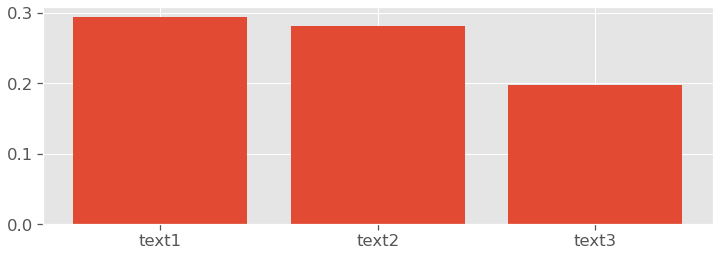

___________________AI_genims_scores_avg:
0.2573857657097694


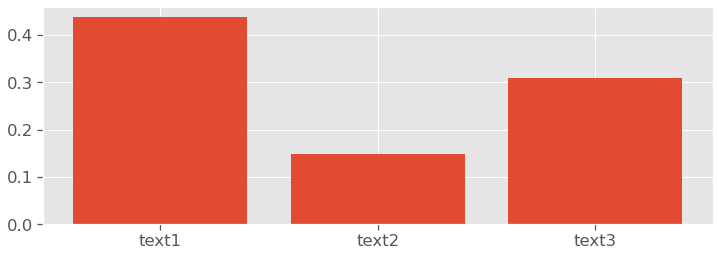

___________________AI_latent_scores_avg:
0.298471887072291


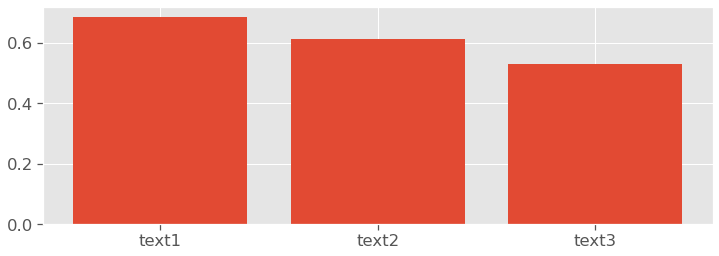

___________________AI_frequency_scores_avg:
0.6096851148311403
___________________The best score:
0.6096851148311403


''

In [63]:
text_summuarization_df._selectBestModel()

Therefore, Spacy Frequency Summarization gives the best results

### Conclusion: general guildline for Enduser
#### Based on the experience of this research, we are proposing the guideline for the end-user is as following: 
##### Step 1: Identify whether authors provide their abstract summarization or create human-made summarization text with the help of experts in the same business domain.
##### Step 2: Normalized the original text with recommended filters, such as stopwords, puncturations, HTML tags, and special characters if necessary.
##### Step 3: For some rare cases, the meager frequent words might have to filter out during the text preprocessing process.
##### Step 4: Consider the parameters for text summarization. Such as summarization ratio, word counts limits. The necessary calculation might need to kick in at the step.
##### Step 5: Prepare at least two models with different approaches based on the A/B evaluation concept. In our case, we choose Gensim, Latent, and Spacy for the modeling. 
##### Step 6: Select at least two metrics to ensure the comparison results among the models are consistent. In our case, we choose NLTK cosine distance and TFID Vector for measurement.
##### Step 7: Compare the results of the models and generate a statistical report. Visualization might be needed for complex system comparison.
##### Step 8: Choose the best model based on step 7.
